In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    RocCurveDisplay, roc_curve, auc
)
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Dataset Loading

In [2]:
# %%data cleaning process
# ------------- Load Raw dataset -----------
file_path = "HR-Employee-Attrition.csv"
df = pd.read_csv(file_path)
print(df.head())
print("the deminision of raw data",df.shape)


   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

## Dataset Cleaning

In [3]:
# We have successfully loaded the dataset
# ------------ Check missing values ------------
missing_counts = df.isna().sum()
print(missing_counts)
print("\n whether there are missing values?",(missing_counts>0).any())
# the result obviously demonstrated that there are no missing amounts.


Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [4]:
obj_col = df.select_dtypes(include="object").columns
print(list(obj_col))
#%%
# IN this case, we found that:
    # Employeecount is always 1
    # Over 18 is always Y
    # standard hours (always 40)
    # Employee Number is a kind of ID, whic does not make sense in preditive.
drop_cols = ["EmployeeCount", "Over18", "StandardHours", "EmployeeNumber"]
df = df.drop(columns=drop_cols)
print("\n After droping the ID columns",df.shape)
# %% Before any process, we convert the target variable to binary. 1/0
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["Attrition"])
y=df["Attrition"]
print("\nTarget distribution:")
print(y.value_counts(normalize=True))
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(exclude="object").columns.tolist()
print("\nCategorical :", categorical_cols)
print("\nNumerical :", numerical_cols)
# “The attrition rate is about 16%, indicating a moderately imbalanced binary classification problem.”


['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

 After droping the ID columns (1470, 31)

Target distribution:
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64

Categorical : ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

Numerical : ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


## EDA


Overall attrition rate: 0.161 (16.1%)

Correlation of numeric features with Attrition:
DistanceFromHome            0.077924
NumCompaniesWorked          0.043494
MonthlyRate                 0.015170
PerformanceRating           0.002889
HourlyRate                 -0.006846
PercentSalaryHike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
DailyRate                  -0.056652
TrainingTimesLastYear      -0.059478
WorkLifeBalance            -0.063939
EnvironmentSatisfaction    -0.103369
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
YearsAtCompany             -0.134392
StockOptionLevel           -0.137145
YearsWithCurrManager       -0.156199
Age                        -0.159205
MonthlyIncome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
TotalWorkingYears          -0.171063
Name: Attrition, dtype: float64


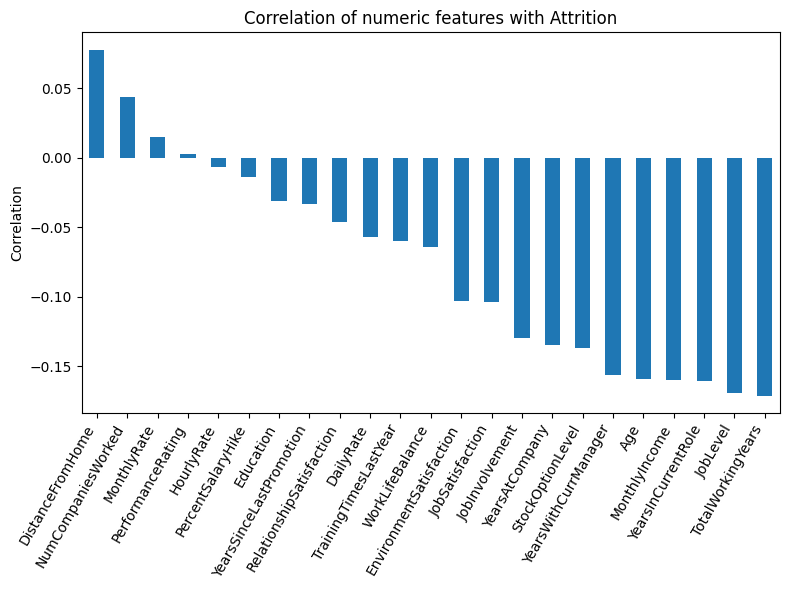


Numeric features ranked by  absolute correlation with Attrition: 
TotalWorkingYears           0.171063
JobLevel                    0.169105
YearsInCurrentRole          0.160545
MonthlyIncome               0.159840
Age                         0.159205
YearsWithCurrManager        0.156199
StockOptionLevel            0.137145
YearsAtCompany              0.134392
JobInvolvement              0.130016
JobSatisfaction             0.103481
EnvironmentSatisfaction     0.103369
DistanceFromHome            0.077924
WorkLifeBalance             0.063939
TrainingTimesLastYear       0.059478
DailyRate                   0.056652
RelationshipSatisfaction    0.045872
NumCompaniesWorked          0.043494
YearsSinceLastPromotion     0.033019
Education                   0.031373
MonthlyRate                 0.015170
PercentSalaryHike           0.013478
HourlyRate                  0.006846
PerformanceRating           0.002889
Name: Attrition, dtype: float64


In [5]:
#%% EDA process
# Overall attrition rate
overall_rate = y.mean()
print(f"\nOverall attrition rate: {overall_rate:.3f} ({overall_rate*100:.1f}%)")
#Attrition vs all NUMERICAL variables, Use correlation between each numeric feature and Attrition (0/1)
corr_with_attrition = df[numerical_cols + ["Attrition"]].corr()["Attrition"]
corr_with_attrition = corr_with_attrition.drop("Attrition").sort_values(ascending=False)
print("\nCorrelation of numeric features with Attrition:")
print(corr_with_attrition)
plt.figure(figsize=(8,6))
corr_with_attrition.plot(kind="bar")
plt.title("Correlation of numeric features with Attrition")
plt.ylabel("Correlation")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()
# Rank numeric features by absolute correlation
num_importance = corr_with_attrition.abs().sort_values(ascending=False)
print("\nNumeric features ranked by  absolute correlation with Attrition: ")
print(num_importance)


=== Attrition rate by JobRole ===
JobRole
Sales Representative         0.397590
Laboratory Technician        0.239382
Human Resources              0.230769
Sales Executive              0.174847
Research Scientist           0.160959
Manufacturing Director       0.068966
Healthcare Representative    0.068702
Manager                      0.049020
Research Director            0.025000
Name: Attrition, dtype: float64


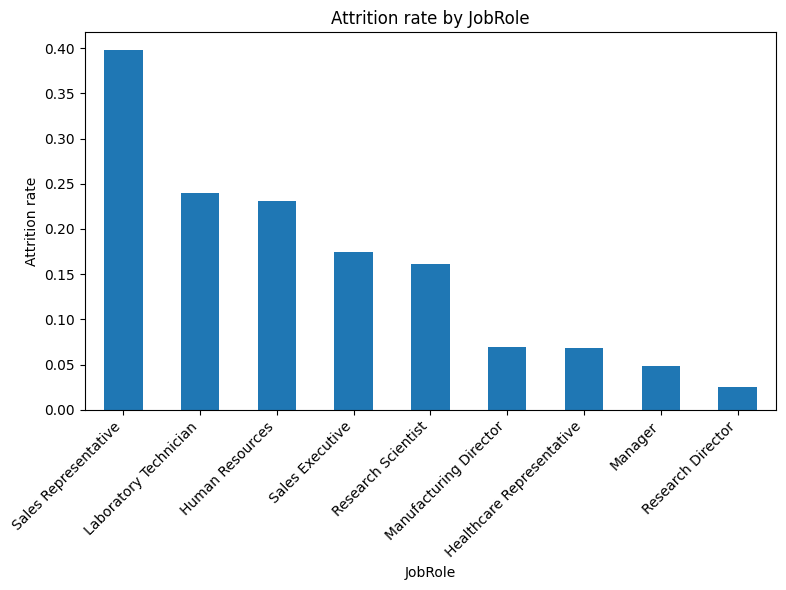


=== Attrition rate by OverTime ===
OverTime
Yes    0.305288
No     0.104364
Name: Attrition, dtype: float64


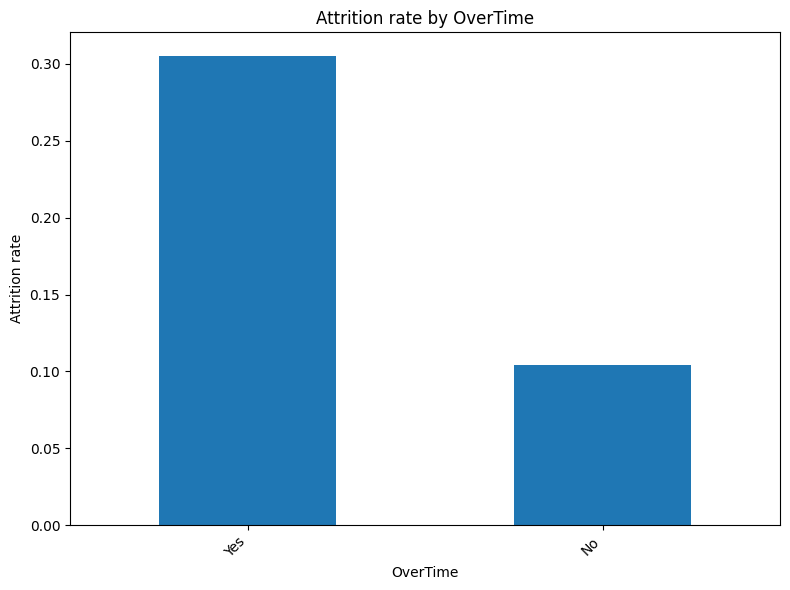


=== Attrition rate by BusinessTravel ===
BusinessTravel
Travel_Frequently    0.249097
Travel_Rarely        0.149569
Non-Travel           0.080000
Name: Attrition, dtype: float64


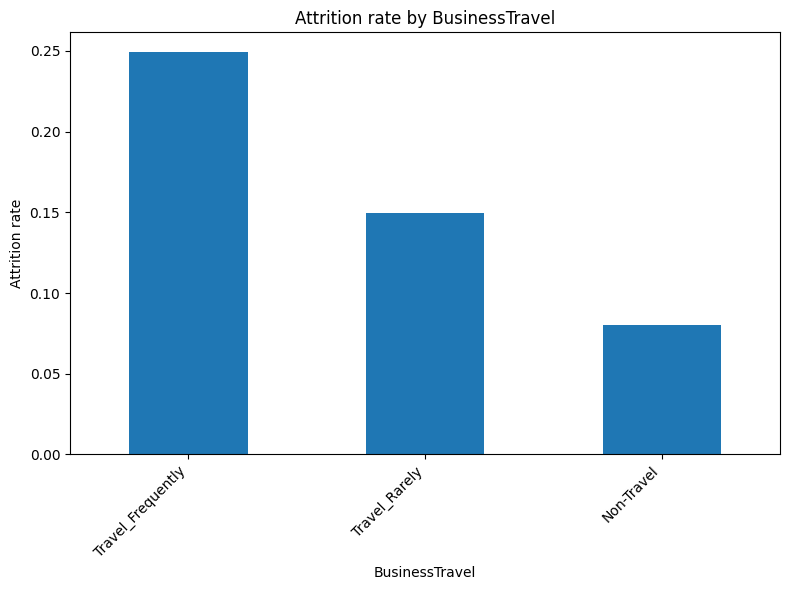


=== Attrition rate by MaritalStatus ===
MaritalStatus
Single      0.255319
Married     0.124814
Divorced    0.100917
Name: Attrition, dtype: float64


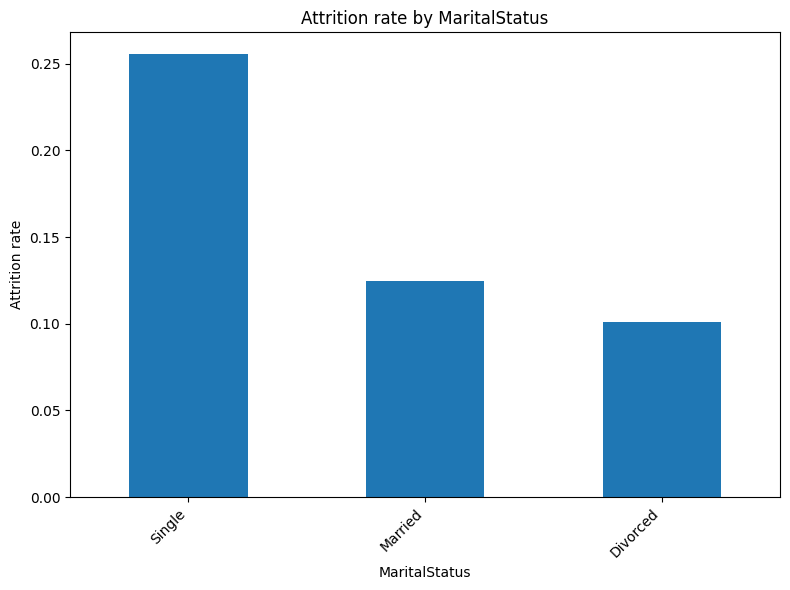


Categorical features ranked by attrition-rate spread (max - min)
JobRole           0.372590
OverTime          0.200924
BusinessTravel    0.169097
MaritalStatus     0.154402
dtype: float64


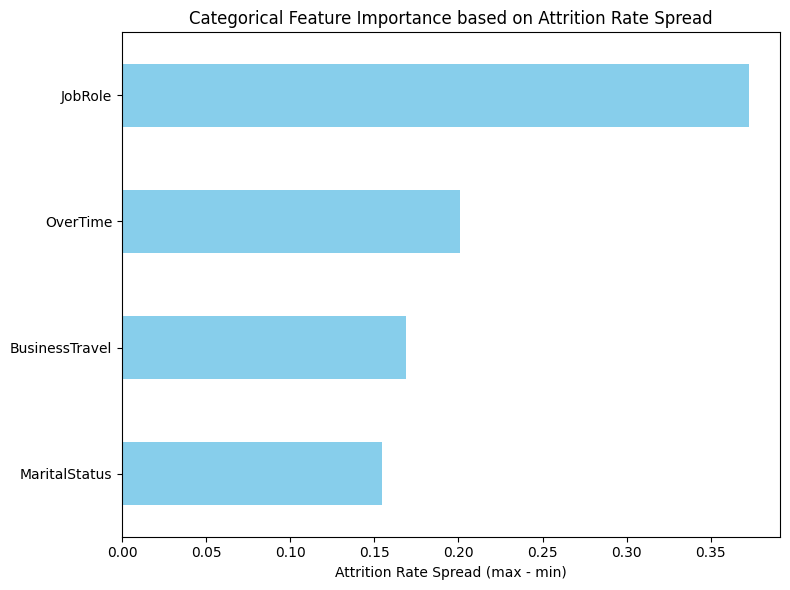

In [23]:
for col in categorical_cols:
    print(f"\n=== Attrition rate by {col} ===")
    rate_by_cat = df.groupby(col)["Attrition"].mean().sort_values(ascending=False)
    print(rate_by_cat)
    plt.figure(figsize=(8,6))
    rate_by_cat.plot(kind="bar")
    plt.ylabel("Attrition rate")
    plt.title(f"Attrition rate by {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
#%% We compare the overall difference for the categorical variable
cat_importance = {}
for col in categorical_cols:
    rates = df.groupby(col)["Attrition"].mean()
    spread = rates.max() - rates.min()
    cat_importance[col] = spread
cat_importance = pd.Series(cat_importance).sort_values(ascending=False)
print("\nCategorical features ranked by attrition-rate spread (max - min)")
print(cat_importance)
plt.figure(figsize=(8, 6))
cat_importance.sort_values().plot(kind="barh", color="skyblue")
plt.xlabel("Attrition Rate Spread (max - min)")
plt.title("Categorical Feature Importance based on Attrition Rate Spread")
plt.tight_layout()
plt.show()


 Overall ranking of features (numeric + categorical)
                     feature  importance         type  \
23                   JobRole    0.372590  categorical   
24                  OverTime    0.200924  categorical   
0          TotalWorkingYears    0.171063      numeric   
1                   JobLevel    0.169105      numeric   
25            BusinessTravel    0.169097  categorical   
2         YearsInCurrentRole    0.160545      numeric   
3              MonthlyIncome    0.159840      numeric   
4                        Age    0.159205      numeric   
5       YearsWithCurrManager    0.156199      numeric   
26             MaritalStatus    0.154402  categorical   
6           StockOptionLevel    0.137145      numeric   
7             YearsAtCompany    0.134392      numeric   
8             JobInvolvement    0.130016      numeric   
9            JobSatisfaction    0.103481      numeric   
10   EnvironmentSatisfaction    0.103369      numeric   
11          DistanceFromHome    0.

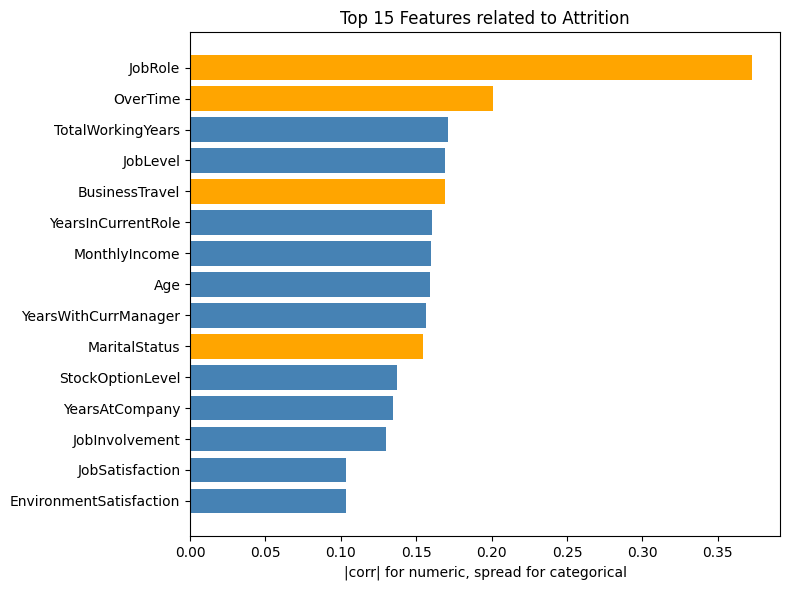

Selected top features: ['JobRole', 'OverTime', 'TotalWorkingYears', 'JobLevel', 'BusinessTravel', 'YearsInCurrentRole', 'MonthlyIncome', 'Age', 'YearsWithCurrManager', 'MaritalStatus']

Selected categorical: ['JobRole', 'OverTime', 'BusinessTravel', 'MaritalStatus']
Selected numerical: ['TotalWorkingYears', 'JobLevel', 'YearsInCurrentRole', 'MonthlyIncome', 'Age', 'YearsWithCurrManager']
X shape: (1470, 10)
Train size: (1176, 10)
Test size : (294, 10)

After SMOTE class distribution:
Attrition
0    986
1    986
Name: count, dtype: int64


In [24]:
# %% Combine numeric and categorical  into one table
num_df = pd.DataFrame({
    "feature": num_importance.index,
    "importance": num_importance.values,
    "type": "numeric",
    "measure": "|correlation with Attrition|"
})
cat_df = pd.DataFrame({
    "feature": cat_importance.index,
    "importance": cat_importance.values,
    "type": "categorical",
    "measure": "attrition rate spread"
})
importance_all = pd.concat([num_df, cat_df], ignore_index=True)
importance_all = importance_all.sort_values("importance", ascending=False)

print("\n Overall ranking of features (numeric + categorical)")
print(importance_all)
top_k = 15
top_features = importance_all.head(top_k).copy()
colors = top_features["type"].map({"numeric": "steelblue", "categorical": "orange"})
plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1], color=colors[::-1])
plt.xlabel("|corr| for numeric, spread for categorical")
plt.title(f"Top {top_k} Features related to Attrition")
plt.tight_layout()
plt.show()
# %% Use selected top 10 features to do the remaining analysis
top_k = 10
selected_features = importance_all["feature"].head(top_k).tolist()
print("Selected top features:", selected_features)
X = df[selected_features].copy()
y = df["Attrition"]
# split the categorial and numerical data that we choosed to forward
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(exclude="object").columns.tolist()

print("\nSelected categorical:", categorical_cols)
print("Selected numerical:", numerical_cols)
print("X shape:", X.shape)
#%% we try to do the one hot encoding and data scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# %% We do the train test split
X_selected = df[selected_features]
y = df["Attrition"]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train_raw.shape)
print("Test size :", X_test_raw.shape)# Transform training & test data
preprocessor.fit(X_train_raw)
X_train_pre = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train_pre, y_train)
print("\nAfter SMOTE class distribution:")
print(y_train.value_counts())





## Baseline Model -- Logistic Regression

In [7]:
# %% We choose Logistic regression as the base model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]
#%% Performance
print("\n Logistic Regression Performance on Test data")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 score :", f1_score(y_test, y_pred))
print("AUC      :", roc_auc_score(y_test, y_prob))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#%% Extract One-Hot feature names
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_features = ohe.get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(ohe_features)



 Logistic Regression Performance on Test data
Accuracy : 0.7210884353741497
Precision: 0.3157894736842105
Recall   : 0.6382978723404256
F1 score : 0.4225352112676056
AUC      : 0.7328796623309501

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       247
           1       0.32      0.64      0.42        47

    accuracy                           0.72       294
   macro avg       0.62      0.69      0.62       294
weighted avg       0.82      0.72      0.75       294



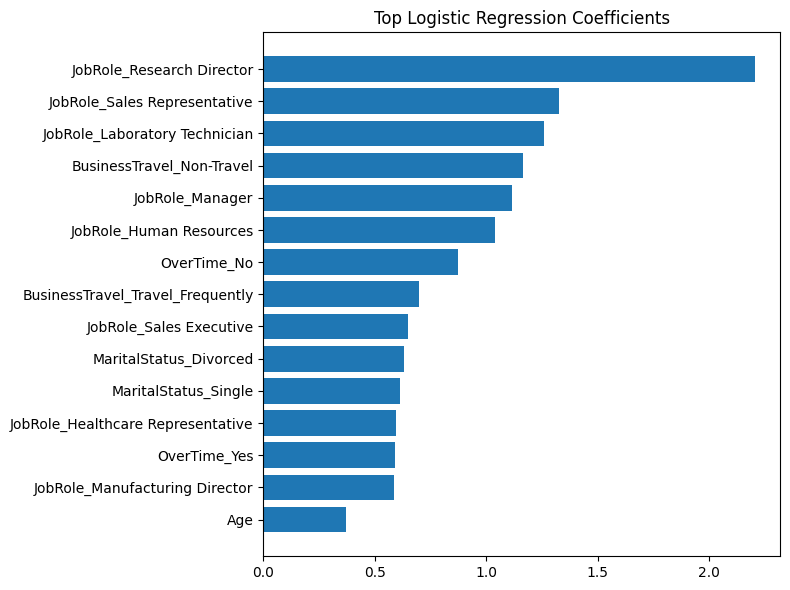

AUC: 0.7328796623309501


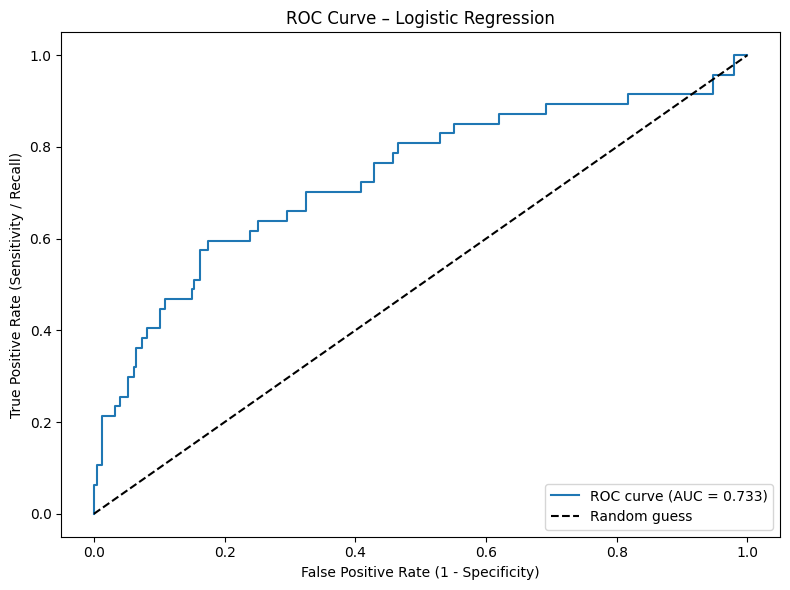

Confusion matrix:
 [[182  65]
 [ 17  30]]


In [8]:
#%% Coefficients
coefs = log_reg.coef_[0]
coef_df = pd.DataFrame({
    "feature": all_features,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)
plt.figure(figsize=(8,6))
plt.barh(coef_df["feature"].head(15)[::-1], coef_df["abs_coef"].head(15)[::-1])
plt.title("Top Logistic Regression Coefficients")
plt.tight_layout()
plt.show()
#%%
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity / Recall)")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

#%% Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion matrix:\n", cm)

<Figure size 400x400 with 0 Axes>

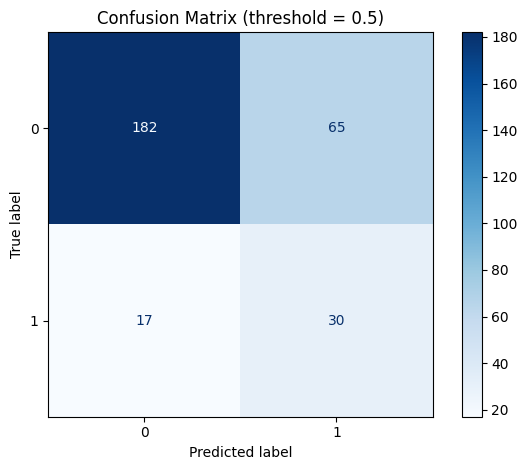

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
plt.figure(figsize=(4, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (threshold = 0.5)")
plt.tight_layout()
plt.show()


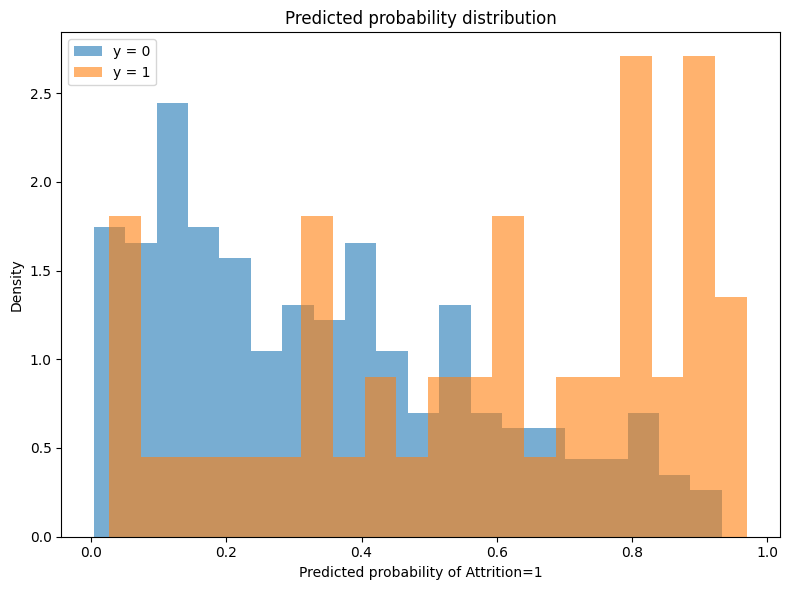

In [10]:
#%% Probability distributions for y=0 and y=1
plt.figure(figsize=(8, 6))
plt.hist(y_prob[y_test == 0], bins=20, alpha=0.6, density=True, label="y = 0")
plt.hist(y_prob[y_test == 1], bins=20, alpha=0.6, density=True, label="y = 1")
plt.xlabel("Predicted probability of Attrition=1")
plt.ylabel("Density")
plt.title("Predicted probability distribution")
plt.legend()
plt.tight_layout()
plt.show()


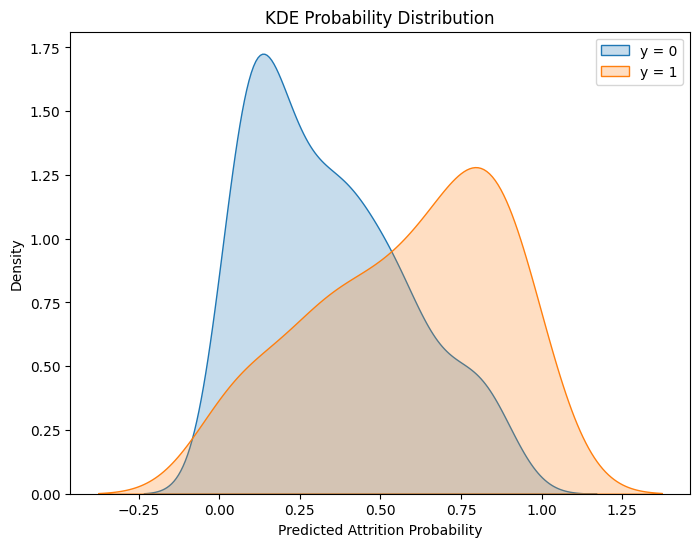

In [11]:
plt.figure(figsize=(8,6))
sns.kdeplot(y_prob[y_test==0], fill=True, label="y = 0")
sns.kdeplot(y_prob[y_test==1], fill=True, label="y = 1")
plt.xlabel("Predicted Attrition Probability")
plt.title("KDE Probability Distribution")
plt.legend()
plt.show()

## Advanced Model 1 — Decision Tree + GridSearchCV + evaluation + feature importance

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

In [13]:
# 1) small-but-meaningful tuning grid
dt = DecisionTreeClassifier(random_state=42)

dt_grid = {
    "max_depth": [3, 5, 8, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "class_weight": [None, "balanced"]
}

dt_gs = GridSearchCV(
    dt,
    param_grid=dt_grid,
    scoring="f1",   # focus on minority class
    cv=5,
    n_jobs=-1
)
dt_gs.fit(X_train, y_train)

best_dt = dt_gs.best_estimator_
print("\n===== Decision Tree Best Params =====")
print(dt_gs.best_params_)
print("Best CV F1:", dt_gs.best_score_)


===== Decision Tree Best Params =====
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1: 0.8522838351334947


In [14]:
# 2) test-set evaluation
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

print("\n===== Decision Tree Performance (Test) =====")
print("Accuracy :", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall   :", recall_score(y_test, y_pred_dt))
print("F1 score :", f1_score(y_test, y_pred_dt))
print("AUC      :", roc_auc_score(y_test, y_prob_dt))


===== Decision Tree Performance (Test) =====
Accuracy : 0.7857142857142857
Precision: 0.36666666666666664
Recall   : 0.46808510638297873
F1 score : 0.411214953271028
AUC      : 0.6571194762684124



Confusion matrix (DT):
 [[209  38]
 [ 25  22]]


<Figure size 400x400 with 0 Axes>

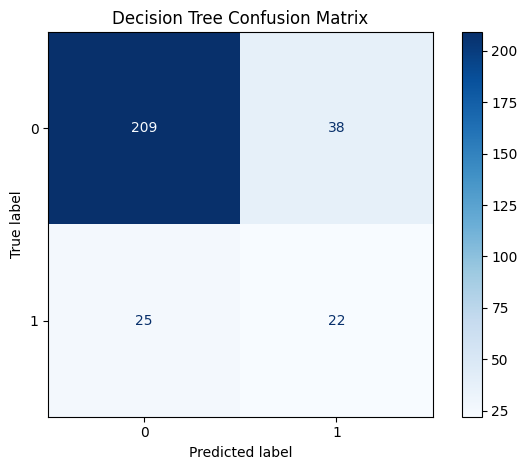

In [15]:
# 3) confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=[0, 1])
print("\nConfusion matrix (DT):\n", cm_dt)

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[0, 1])
plt.figure(figsize=(4, 4))
disp_dt.plot(cmap="Blues", values_format="d")
plt.title("Decision Tree Confusion Matrix")
plt.tight_layout()
plt.show()


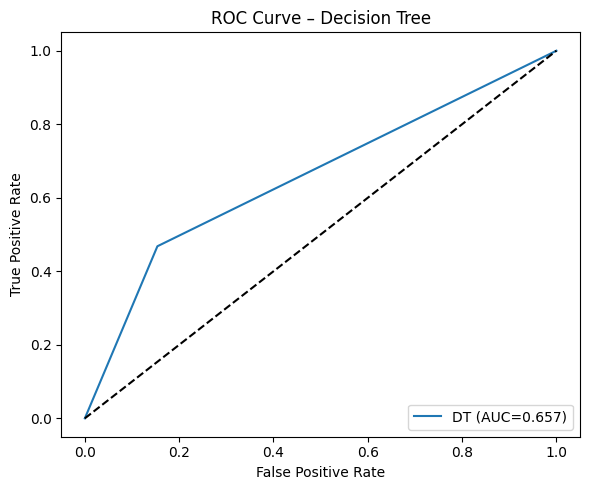

In [16]:
# 4) ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(6, 5))
plt.plot(fpr_dt, tpr_dt, label=f"DT (AUC={roc_auc_dt:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

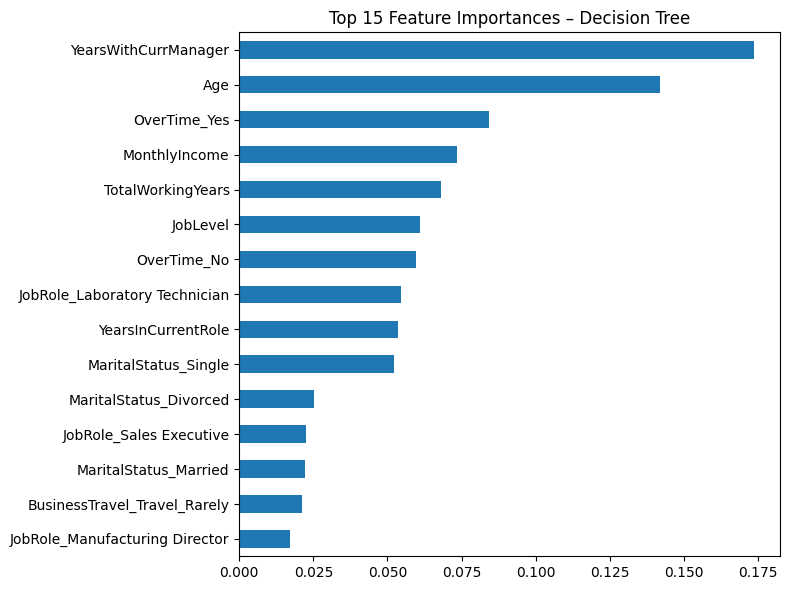

In [17]:
# 5) Feature importance (tree-based)
dt_importance = pd.Series(best_dt.feature_importances_, index=all_features)
dt_importance = dt_importance.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
dt_importance.head(15)[::-1].plot(kind="barh")
plt.title("Top 15 Feature Importances – Decision Tree")
plt.tight_layout()
plt.show()

# summary
dt_best_params = dt_gs.best_params_
dt_test_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "AUC": roc_auc_score(y_test, y_prob_dt),
}

## Advanced Model 2 — Random Forest + tuning + evaluation + feature importance

In [18]:
# 1) Define model + reasonable grid
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_grid = {
    "n_estimators": [200, 400],          # number of trees
    "max_depth": [None, 8, 15],          # control overfitting
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"],    # good defaults for high-dim OHE
    "class_weight": [None, "balanced"]   # compare w/ imbalance handling
}

rf_gs = GridSearchCV(
    rf,
    param_grid=rf_grid,
    scoring="f1",   # consistent with your attrition-imbalance goal
    cv=5,
    n_jobs=-1
)

rf_gs.fit(X_train, y_train)
best_rf = rf_gs.best_estimator_

print("\n===== Random Forest Best Params =====")
print(rf_gs.best_params_)
print("Best CV F1:", rf_gs.best_score_)



===== Random Forest Best Params =====
{'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1: 0.9109221767584679


In [19]:
# 2) Test-set evaluation
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("\n===== Random Forest Performance (Test) =====")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 score :", f1_score(y_test, y_pred_rf))
print("AUC      :", roc_auc_score(y_test, y_prob_rf))



===== Random Forest Performance (Test) =====
Accuracy : 0.8605442176870748
Precision: 0.59375
Recall   : 0.40425531914893614
F1 score : 0.4810126582278481
AUC      : 0.7395985873029547



Confusion matrix (RF):
 [[234  13]
 [ 28  19]]


<Figure size 400x400 with 0 Axes>

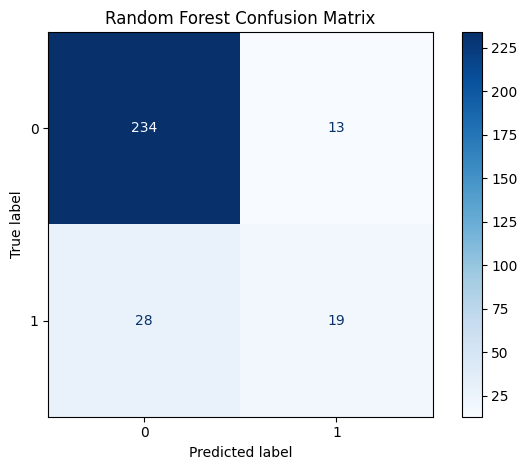

In [20]:
# 3) Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
print("\nConfusion matrix (RF):\n", cm_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])
plt.figure(figsize=(4, 4))
disp_rf.plot(cmap="Blues", values_format="d")
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

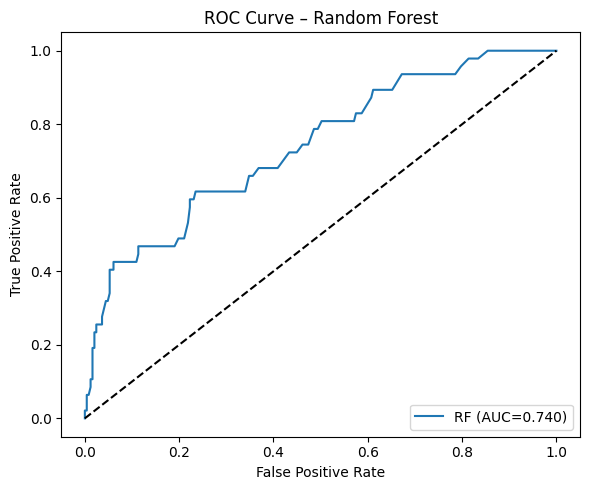

In [21]:
# 4) ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

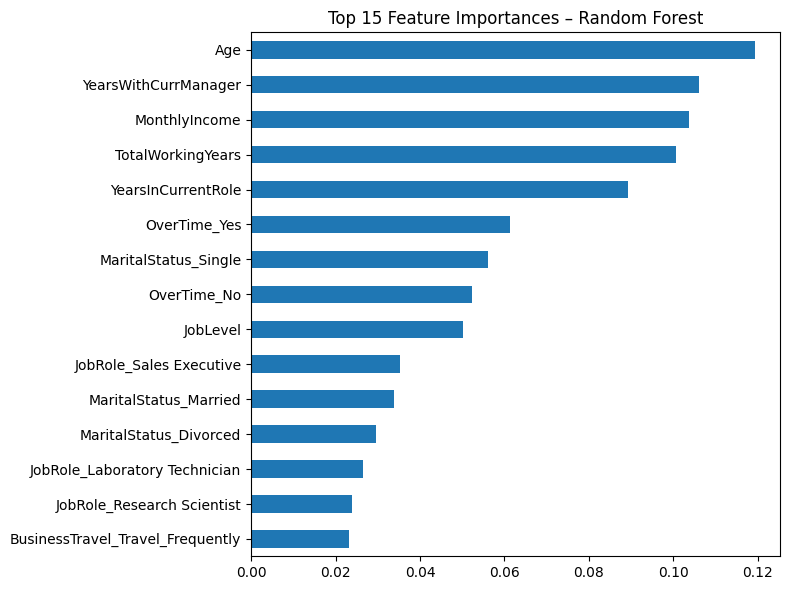

In [22]:
# 5) Feature importance (tree-based)
rf_importance = pd.Series(best_rf.feature_importances_, index=all_features)
rf_importance = rf_importance.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
rf_importance.head(15)[::-1].plot(kind="barh")
plt.title("Top 15 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

# summary
rf_best_params = rf_gs.best_params_
rf_test_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "AUC": roc_auc_score(y_test, y_prob_rf),
}

 ## Advanced Model 3 — Gradient Boosting + tuning + evaluation + feature importance

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
# 1) Define model + reasonable grid
gb = GradientBoostingClassifier(random_state=42)

gb_grid = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0]
}

gb_gs = GridSearchCV(
    gb,
    param_grid=gb_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

gb_gs.fit(X_train, y_train)
best_gb = gb_gs.best_estimator_

print("\n===== Gradient Boosting Best Params =====")
print(gb_gs.best_params_)
print("Best CV F1:", gb_gs.best_score_)


===== Gradient Boosting Best Params =====
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best CV F1: 0.874703755158085


In [27]:
# 2) Test-set evaluation
y_pred_gb = best_gb.predict(X_test)
y_prob_gb = best_gb.predict_proba(X_test)[:, 1]

print("\n===== Gradient Boosting Performance (Test) =====")
print("Accuracy :", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb))
print("Recall   :", recall_score(y_test, y_pred_gb))
print("F1 score :", f1_score(y_test, y_pred_gb))
print("AUC      :", roc_auc_score(y_test, y_prob_gb))


===== Gradient Boosting Performance (Test) =====
Accuracy : 0.8435374149659864
Precision: 0.5128205128205128
Recall   : 0.425531914893617
F1 score : 0.46511627906976744
AUC      : 0.7493324145059866



Confusion matrix (GB):
 [[228  19]
 [ 27  20]]


<Figure size 400x400 with 0 Axes>

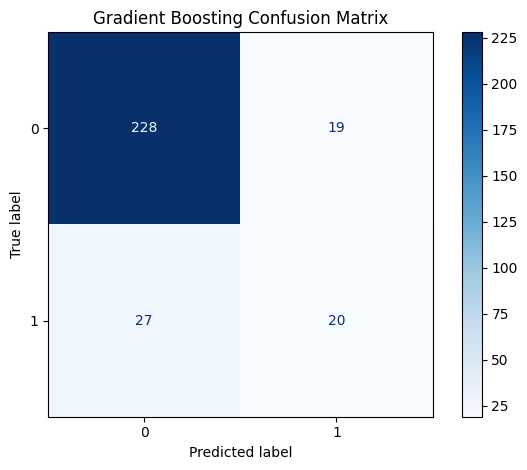

In [28]:
# 3) Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb, labels=[0, 1])
print("\nConfusion matrix (GB):\n", cm_gb)

disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=[0, 1])
plt.figure(figsize=(4, 4))
disp_gb.plot(cmap="Blues", values_format="d")
plt.title("Gradient Boosting Confusion Matrix")
plt.tight_layout()
plt.show()

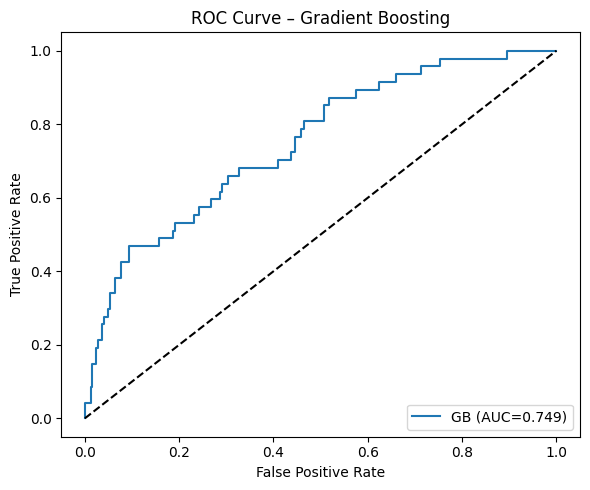

In [29]:
# 4) ROC curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_gb, tpr_gb, label=f"GB (AUC={roc_auc_gb:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Gradient Boosting")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

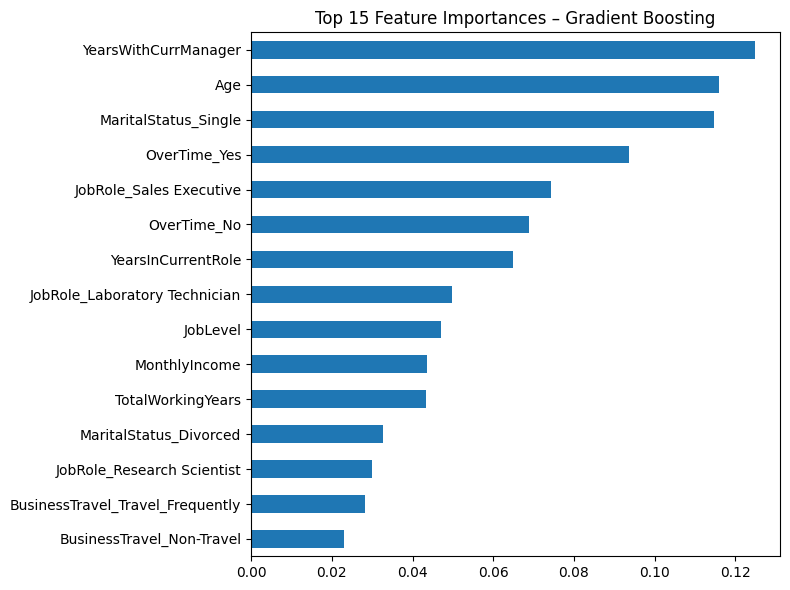

In [30]:
# 5) Feature importance
gb_importance = pd.Series(best_gb.feature_importances_, index=all_features)
gb_importance = gb_importance.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
gb_importance.head(15)[::-1].plot(kind="barh")
plt.title("Top 15 Feature Importances – Gradient Boosting")
plt.tight_layout()
plt.show()

# summary
gb_best_params = gb_gs.best_params_
gb_test_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb),
    "Recall": recall_score(y_test, y_pred_gb),
    "F1": f1_score(y_test, y_pred_gb),
    "AUC": roc_auc_score(y_test, y_prob_gb),
}

In [33]:
threshold = 0.30  # Example: Flag anyone with >30% risk
y_pred_adjusted = (y_prob_gb >= threshold).astype(int)

# Now check metrics again
print("New Recall:", recall_score(y_test, y_pred_adjusted))
print("New Precision:", precision_score(y_test, y_pred_adjusted))

New Recall: 0.5319148936170213
New Precision: 0.3246753246753247


In [34]:
threshold = 0.25  # Example: Flag anyone with >30% risk
y_pred_adjusted = (y_prob_gb >= threshold).astype(int)

# Now check metrics again
print("New Recall:", recall_score(y_test, y_pred_adjusted))
print("New Precision:", precision_score(y_test, y_pred_adjusted))

New Recall: 0.6170212765957447
New Precision: 0.29


## Interpretation and Business Recommendations

This project successfully met the objective of predicting employee attrition using the IBM HR Analytics dataset. By progressing from a baseline Logistic Regression model to advanced ensemble methods (Random Forest and Gradient Boosting), we identified distinct trade-offs between predictive accuracy and sensitivity.

#### A. Model Performance Analysis
We evaluated models based on their ability to distinguish "Leavers" (Attrition=1) from "Stayers" (Attrition=0).

* **The Baseline (Logistic Regression):** This model acted as a "high-sensitivity" net. With a Recall of **63.8%**, it successfully identified nearly two-thirds of the employees who left. However, its low Precision (**31.6%**) indicated a high rate of false alarms, meaning it often flagged satisfied employees as being at risk.
* **The Advanced Models (Random Forest & Gradient Boosting):** The ensemble methods significantly improved overall stability. The Random Forest achieved the highest Accuracy (**86.1%**) and Precision (**59.4%**). However, at the default decision threshold ($0.5$), these models were conservative, yielding lower Recall (~40-43%).
* **The "Sweet Spot" (Gradient Boosting Optimization):** The Gradient Boosting model achieved the highest AUC (**0.749**), indicating it had the strongest underlying ability to rank employees by risk. By applying **threshold moving** (lowering the decision threshold to **0.25**), we increased the Gradient Boosting Recall to **61.7%**, effectively matching the baseline's sensitivity while maintaining a robust underlying probability ranking.

#### B. Key Drivers of Attrition
Consistent across both the linear coefficients and tree-based feature importance plots, the following factors were identified as the strongest predictors of turnover:

1.  **OverTime:** This was consistently the top predictor. Employees working overtime are at a significantly higher risk of burnout and subsequent attrition.
2.  **Job Role:** Specific roles, particularly **Sales Representatives**, showed disproportionately high attrition rates compared to stable roles like **Managers** and **Research Directors**.
3.  **Monthly Income:** Lower income levels correlated strongly with higher probability of leaving, suggesting that compensation remains a primary friction point.
4.  **Years With Current Manager:** This feature appeared in the top importance lists for all advanced models. A lack of stability with a manager (short tenure) is a critical warning sign, validating the adage that "employees leave managers, not companies."

#### C. Business Recommendations
Based on these findings, we recommend the following actions for Human Resource Management:

* **Intervention Strategy:** Deploy the **Gradient Boosting model** with a flexible threshold. Use the default threshold ($0.5$) to identify "High Risk" employees for immediate intervention (e.g., retention bonuses). Use the adjusted threshold ($0.25$) to identify a broader "Watch List" for soft interventions, such as check-in meetings or engagement surveys.
* **Policy Review:** Review **OverTime** policies immediately. Since overtime is a leading indicator of attrition, HR should investigate if this is driven by understaffing or inefficient processes.
* **Managerial Training:** Given the importance of `YearsWithCurrManager`, the organization should focus on leadership development and smooth transition plans when managers change, as these transition periods are high-risk windows for employee turnover.